In [ ]:
import pandas as pd

housing_df = pd.read_csv('datasets/housing/housing.csv')
housing_df.info()
housing_df.head()

In [ ]:
housing_df['ocean_proximity'].value_counts()
housing_df.describe()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

housing_df.hist(bins=50, figsize=(20,15))
plt.show()

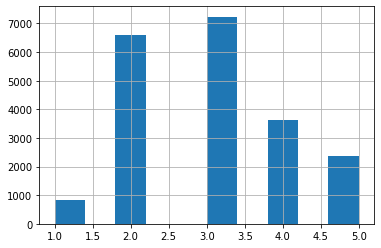

In [27]:
# Stratified Sampling of the "median_income"
import numpy as np
housing_df['income_cat'] = pd.cut(housing_df['median_income'], bins=[0, 1.5, 3.0, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])

housing_df['income_cat'].hist()

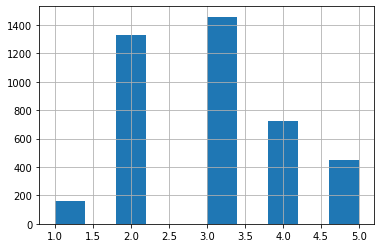

In [28]:
# Random Split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_df, train_size=0.8, random_state=41)
test_set['income_cat'].hist()

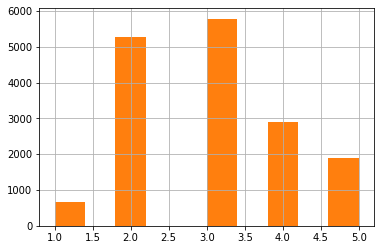

In [31]:
# Stratified Split
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=41)

for train_index, test_index in split.split(housing_df, housing_df['income_cat']):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

len(strat_test_set)
len(strat_train_set)

strat_test_set['income_cat'].hist()
strat_train_set['income_cat'].hist()

for set_ in (strat_test_set, strat_train_set):
    set_.drop('income_cat', axis=1, inplace=True)